# Run this in the CLIMADA environment and if you encounter any problems run !pip uninstall pyrepo-mcda

In [1]:
# Install the required package

!pip install pyrepo-mcda

## Part 1: Creating the data frame metrics_df

**Define the enities object to investigate**

In [2]:
# *************** User-modifiable parameters ***************

# Defines the entity and hazard set to be used
# Choose one of the following:
# 'CanTho_PLFL' - Can Tho, Vietnam, flood hazard
# 'CLIMADA_DEMO' - CLIMADA demo entity and hazard set

file_str = 'CLIMADA_DEMO'   # or 'CLIMADA_DEMO'  'CanTho_PLFL'

# *************** End of user-modifiable parameters ***************


**Load entitites and hazards**

In [3]:
from climada.entity import Entity
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.util.api_client import Client
from climada.hazard import Hazard

from MCDM.utils import CURRENT_YEAR, FUTURE_YEAR
import copy


## Entities and hazards containers
# Entities should be defined in the following way:
#       1) with a key refering to a reference name, example 'Assets', 'People', 'Infrastructure', or even 'Data_Provider_1' and 'Data_Provider_2'
#       2) and a value being the entity object for the current and future year
# Example: ent_dict = {'Assets': {'today': Entity(), 'future':Entity()},
#                     'People': {'today': Entity(), 'future':Entity()}},
#                     'Infrastructure': {'today': Entity(), 'future':Entity()}}

# Parameters
grwth_rate_dict = {'People': 0.02, 'Assets': 0.02 } # growth rate for the future exposure data

# Load the entities and hazards
if file_str == 'CLIMADA_DEMO':
    ## Entities
    ent_dict = {'Assets': {'today': Entity.from_excel(ENT_DEMO_TODAY), 'future':Entity.from_excel(ENT_DEMO_FUTURE)}}
    ## Hazards
    haz_dict = {'TCs': {'today': Hazard.from_hdf5(HAZ_DEMO_H5), 'future': Hazard.from_hdf5(HAZ_DEMO_H5)}}
    haz_dict['TCs']['future'].intensity *= 1.5 # double the intensity of the future hazard


elif file_str == 'CanTho_PLFL':

    ## Entities
    # Current exposure data - Assets and People
    ent_dict=   {'Assets': {'today': Entity.from_excel('Data/Entities/entity_TODAY_CanTho_PLFL_Assets.xlsx')},
                'People': {'today': Entity.from_excel('Data/Entities/entity_TODAY_CanTho_PLFL_People.xlsx')}
                }
    # Future exposure data - Assets
    ent_dict['Assets']['future'] = copy.deepcopy(ent_dict['Assets']['today'])
    ent_dict['Assets']['future'].exposures.gdf.value *= (1+grwth_rate_dict['Assets'])**(FUTURE_YEAR-CURRENT_YEAR)
    # Future exposure data - People
    ent_dict['People']['future'] = copy.deepcopy(ent_dict['People']['today'])
    ent_dict['People']['future'].exposures.gdf.value *= (1+grwth_rate_dict['People'])**(FUTURE_YEAR-CURRENT_YEAR)

    ## Hazards
    # API client
    client = Client()
    # Hazards
    haz_dict = {'river_flood': {'today': client.get_hazard(hazard_type='river_flood', properties={'country_iso3alpha': 'VNM', 'climate_scenario': 'historical'}),
                                'future': client.get_hazard(hazard_type='river_flood', properties={'country_iso3alpha': 'VNM', 'climate_scenario': 'rcp26', 'year_range': '2030_2050'})
                                }
                }




/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


**Genereate the metrics data frame**

In [4]:
from MCDM.utils import generate_metrics, RISK_FNCS_DICT # Import the risk functions dictionary (also default risk functions are defined in the utils.py file)
import pandas as pd
from tabulate import tabulate
from IPython.display import clear_output
import numpy as np

# Check if the file exists
try:
    # Load previous metrics dataframe
    metrics_df = pd.read_csv(f'Data/Metrics/{file_str}.csv')
except:
    #%% Generate metrics dataframe
    metrics_df = generate_metrics(haz_dict, ent_dict, risk_fncs_dict = RISK_FNCS_DICT, file_output = file_str)

    # Add additional fictive metrics to the dataframe - APPROV and FEAS
    temp_df = pd.DataFrame(metrics_df['measure'].unique(), columns=['measure'])
    temp_df['approv'] = [np.random.randint(1, 5) for _ in range(len(temp_df))]
    temp_df['feas'] = np.random.rand(len(temp_df))
    extra_metrics_df = pd.merge(metrics_df, temp_df, on='measure')

# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
# However, if intrested in the output, comment the following line
clear_output()

# Print the first few rows of the dataframe
print(f'Metrics in the {file_str} file')
print('---------------------------')
print(tabulate(metrics_df.head(), headers='keys', tablefmt='psql'))
# Get all the columns of the dataframe ben_ or bcr_ or npv_ + RISK_FNCS_DICT.keys() + ent_dict.keys()
all_crit_cols = [col for col in metrics_df.columns if 'ben_' in col or 'bcr_' in col or 'npv_' in col or 'approv' in col or 'cost' in col or 'feas' in col]
print(f'The criteria columns of the metrics dataframe are: \n{all_crit_cols}')
print('---------------------------')




Metrics in the CLIMADA_DEMO file
---------------------------
+----+-------------------+----------+------------+---------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+----------+----------+
|    | measure           | hazard   | haz_type   |   cost_Assets |   ben_aai_Assets |   bcr_aai_Assets |   npv_aai_Assets |   ben_rp250_Assets |   bcr_rp250_Assets |   npv_rp250_Assets |   approv |     feas |
|----+-------------------+----------+------------+---------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+----------+----------|
|  0 | Beach nourishment | TCs      | TC         |   1.728e+09   |      4.5172e+09  |      2.61412     |      1.08382e+10 |        2.99569e+11 |            173.361 |        7.72525e+11 |        3 | 0.337511 |
|  1 | Building code     | TCs      | TC         |   9.2e+09     |      3.83884e+09 |      0.417265    

**Description metrics – Criteria of choice**

| Metric            | Description                                                         | Objective | Example Utility |
|-------------------|---------------------------------------------------------------------|-----------|-----------------|
| cost_Assets       | Discounted cost of the measure given by entity named "Assets"                          | Minimize  |                 |
| ben_aai_Assets    | Averted risk in comparison to no measure, based on avg. annual impact             | Maximize  | Identifies cost-effective measures. Usefule for excluding, i.e., filtering, non-cost-efficient measures.|
| bcr_aai_Assets    | Benefit-to-cost ratio, based on avg. annual impact                  | Maximize  |                 |
| npv_aai_Assets    | Total NPV of risk, with measure, based on avg. annual impact        | Minimize  | Enables identification of intolerable risk levels, such as assets or populations remaining at risk. |
| ben_rp250_Assets  | Averted risk in comparison to no measure, based on 250-year return period         | Maximize  | Highlights measures reducing extreme risk |
| bcr_rp250_Assets  | Benefit-to-cost ratio, based on 250-year return period              | Maximize  |                 |
| npv_rp250_Assets  | Total NPV of risk, with measure, based on 250-year return period    | Minimize  |                 |
| approv            | Criteria values representing public approval                        | Maximize  |                 |
| feas              | Criteria values representing feasibility                            | Maximize  |                 |


# Part 2: Ranking the alternatives

#### Default Rankings

The available alternatives are:
---------------------------
+----+------------------+-------------------+
|    | Alternative ID   | measure           |
|----+------------------+-------------------|
|  0 | A1               | Beach nourishment |
|  1 | A2               | Building code     |
|  2 | A3               | Mangroves         |
|  3 | A4               | Seawall           |
|  4 | A5               | no measure        |
+----+------------------+-------------------+


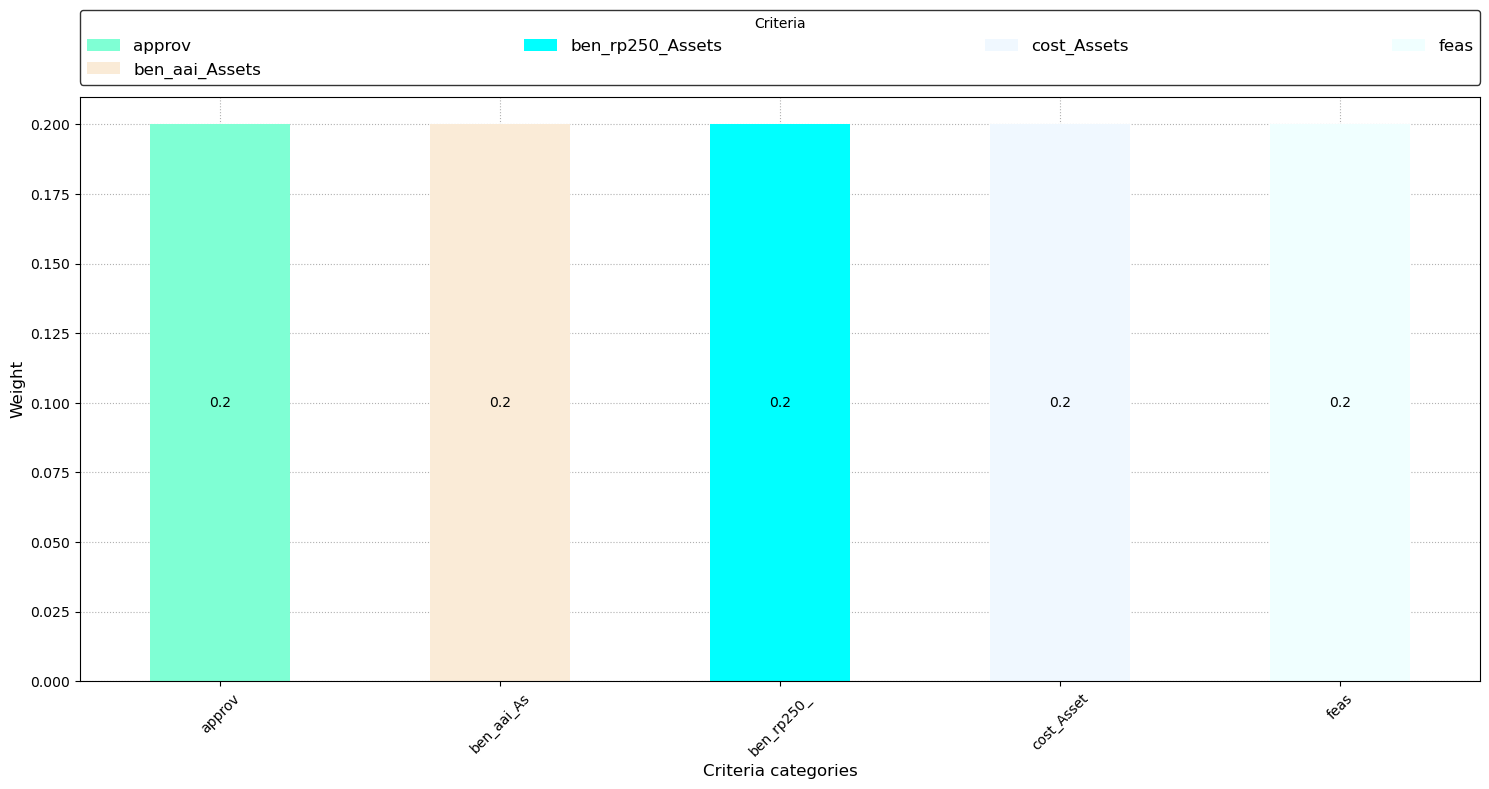

In [5]:
from MCDM.DecisionMatrix import DecisionMatrix  # Import DecisionMatrix module

# *************** User-modifiable parameters ***************

alt_cols = ['measure'] # Columns in metrics_df that contains the alternatives
crit_cols = [col for col in all_crit_cols if 'bcr' not in col and 'npv' not in col] # Columns in metrics_df that contains the criteria
objectives = {crit: -1 if 'cost' in crit else 1 for crit in crit_cols} # Dictionary of weights. Default is equal for all criteria
weights = {} # Dictionary of weights. Default is equal for all criteria

# *************** End of user-modifiable parameters ***************


# Initialize the decision matrix object
dm = DecisionMatrix(metrics_df=metrics_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols) # weights=weights)

# Print the alternatives
print('The available alternatives are:')
print('---------------------------')
print(tabulate(dm.alternatives_df, headers='keys', tablefmt='psql'))

# Plot the criteria weights
dm.plot_criteria()

# Rank the alternatives
ranks_output = dm.calc_rankings()

**Display the rankings for individual criteria and MCDM methods**

The performance of the alternatives based on each criteria is:
---------------------------
+------------------+-------------------+---------------+------------------+--------------------+----------+--------+
| Alternative ID   | measure           |   cost_Assets |   ben_aai_Assets |   ben_rp250_Assets |   approv |   feas |
|------------------+-------------------+---------------+------------------+--------------------+----------+--------|
| A1               | Beach nourishment |             3 |                2 |                  2 |        3 |      4 |
| A2               | Building code     |             5 |                3 |                  3 |        1 |      5 |
| A3               | Mangroves         |             2 |                1 |                  1 |        1 |      2 |
| A4               | Seawall           |             4 |                4 |                  4 |        3 |      1 |
| A5               | no measure        |             1 |                5 |               

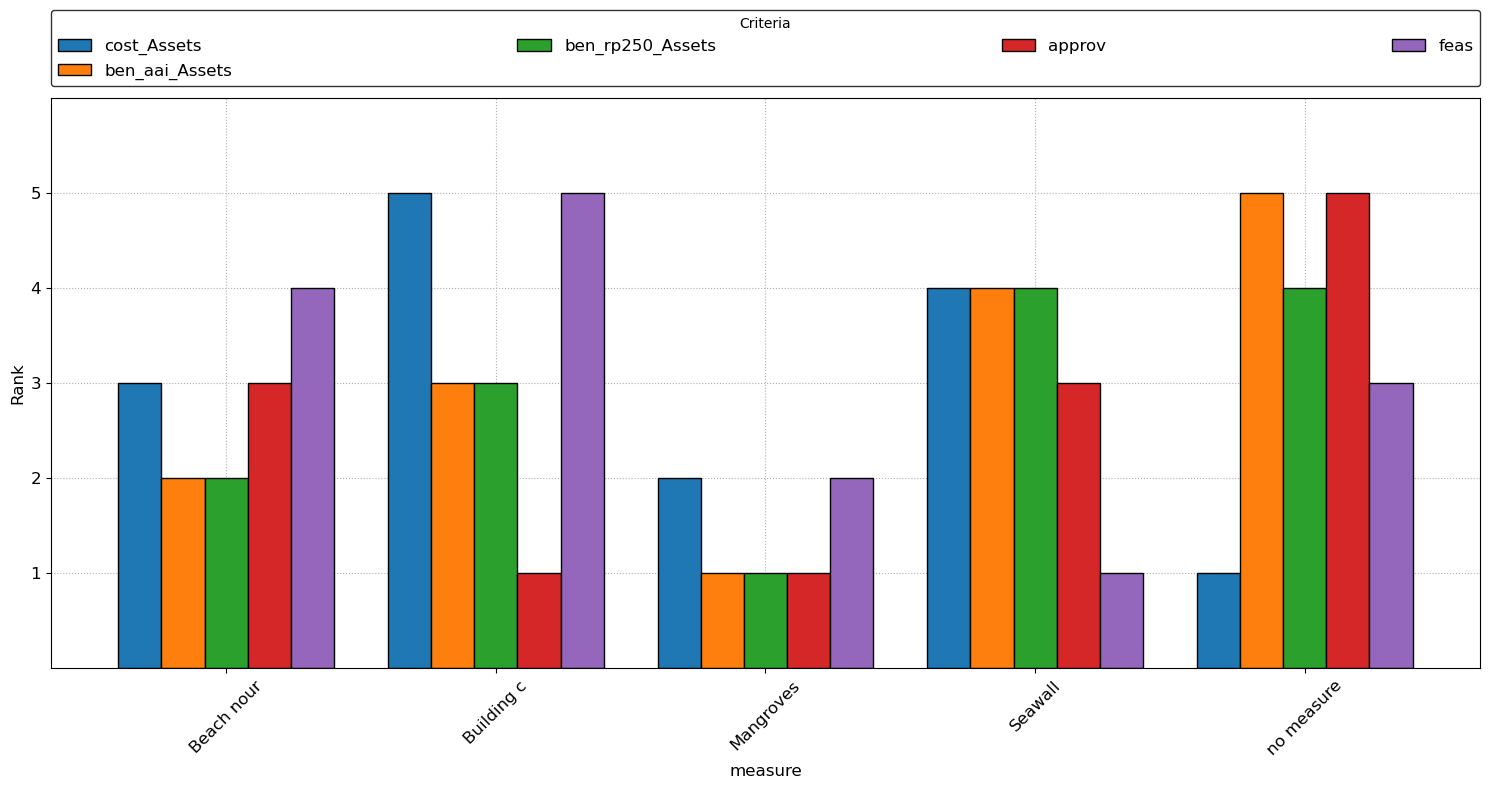

The performance of the alternatives given by the MCDM methods is:
---------------------------
+------------------+-------------------+-------+----------+-------+------------+
| Alternative ID   | measure           |   AHP |   Topsis |   Saw |   copeland |
|------------------+-------------------+-------+----------+-------+------------|
| A3               | Mangroves         |     1 |        1 |     1 |          1 |
| A1               | Beach nourishment |     2 |        2 |     2 |          2 |
| A2               | Building code     |     3 |        3 |     3 |          3 |
| A4               | Seawall           |     4 |        4 |     5 |          4 |
| A5               | no measure        |     5 |        5 |     4 |          5 |
+------------------+-------------------+-------+----------+-------+------------+




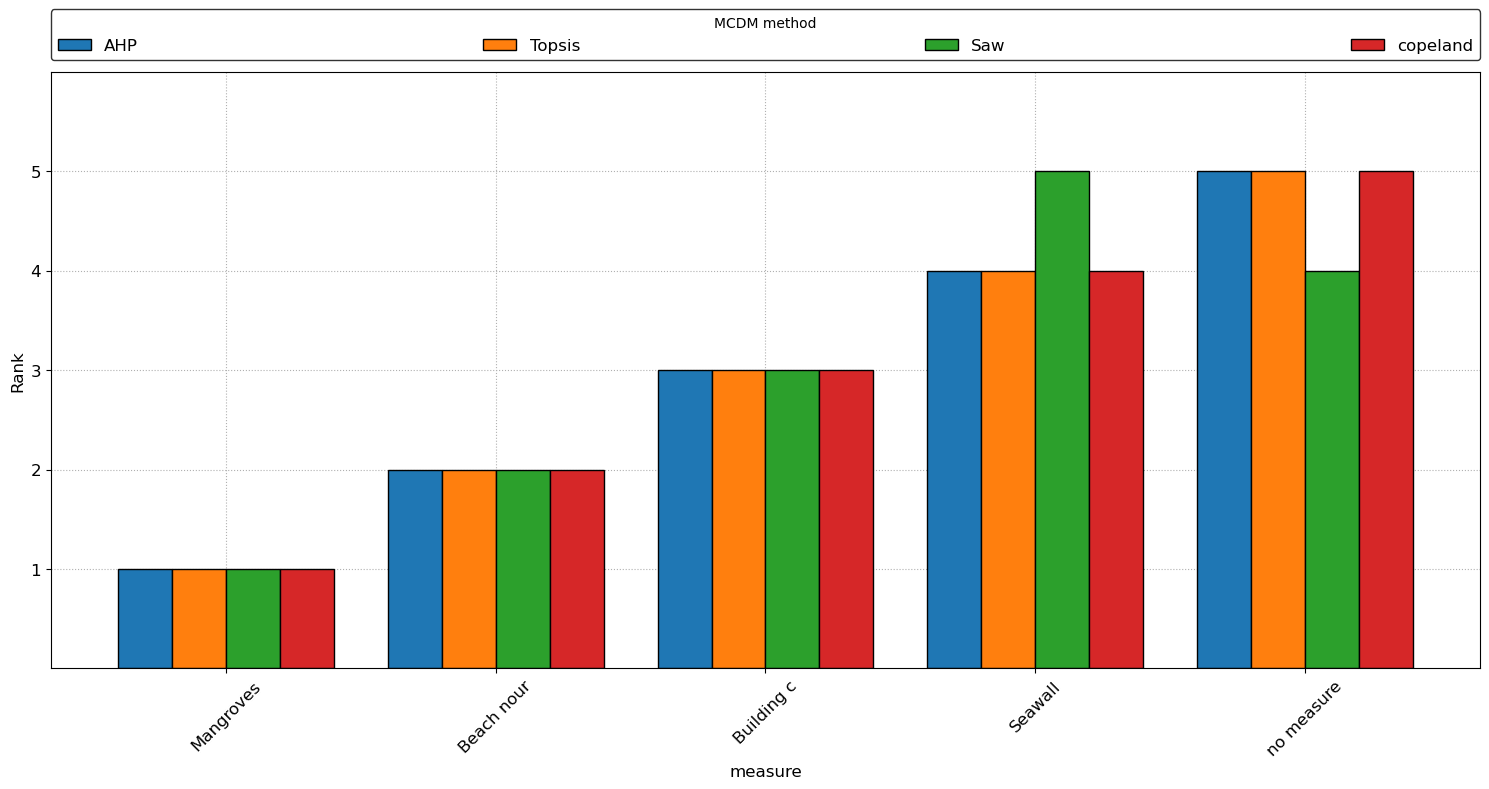

In [6]:
# *************** User-modifiable parameters ***************

disp_rnk_cols = [] # Select specifc columns to display in the rankings
sort_by_col = 'copeland' # Select the column to sort the rankings by either MCDM,
alt_name_col = 'measure' # Select the column to use as the alternative name
transpose = False # Select if the plot should be transposed

# *************** End of user-modifiable parameters ***************

print('The performance of the alternatives based on each criteria is:')
print('---------------------------')
# Print the rankings - Criteria
ranks_output.print_rankings(disp_rnk_cols=disp_rnk_cols, rank_type='criteria')
# Plot the rankings -Criteria
ranks_output.plot_ranks(disp_rnk_cols=disp_rnk_cols, alt_name_col = alt_name_col, rank_type='criteria')

print('The performance of the alternatives given by the MCDM methods is:')
print('---------------------------')
# Print the rankings - MCDM methods
ranks_output.print_rankings(disp_rnk_cols=disp_rnk_cols, rank_type='MCDM', sort_by_col=sort_by_col)
# Plot the rankings - MCDM methods
ranks_output.plot_ranks(disp_rnk_cols=disp_rnk_cols, alt_name_col = alt_name_col, rank_type='MCDM', sort_by_col=sort_by_col, transpose=transpose)

#### Customized ranking methods

| Method  | Approach Description                                                  | When to Use                                      | Limitations / When Not to Use                                      |
|---------|-----------------------------------------------------------------------|--------------------------------------------------|--------------------------------------------------------------------|
| SAW     | Scores options by summing weighted ratings.                           | Straightforward decisions with many criteria.    | Avoid if criteria are correlated or if there's uncertainty in weights. Not ideal for non-linear or complex interactions between criteria. |
| AHP     | Prioritizes options using pairwise comparisons and given weights.     | Decisions where criteria hierarchy is important.  | Not recommended for decisions with closely linked (interdependent) criteria. Problematic if weights or priorities are volatile or ambiguous. |
| TOPSIS  | Ranks options based on distance to an ideal solution.                 | Ideal for balanced performance across criteria.   | Less effective in scenarios with significant outliers or when fine distinctions between very similar options matter. |
| Copeland| Scores based on majority wins in pairwise comparisons.                | Group decisions or consensus is needed.          |  |


Table below shows the excluded alternatives, i.e., not satifying constraints,
where True if particular constraint is satisfied and False if not. 
.
.
+----+------------------+---------------+------------------+-------+
|    | Alternative ID   | measure       | ben_aai_Assets   | bcr   |
|----+------------------+---------------+------------------+-------|
|  0 | A2               | Building code | True             | False |
|  1 | A4               | Seawall       | True             | False |
|  2 | A5               | no measure    | False            | False |
+----+------------------+---------------+------------------+-------+


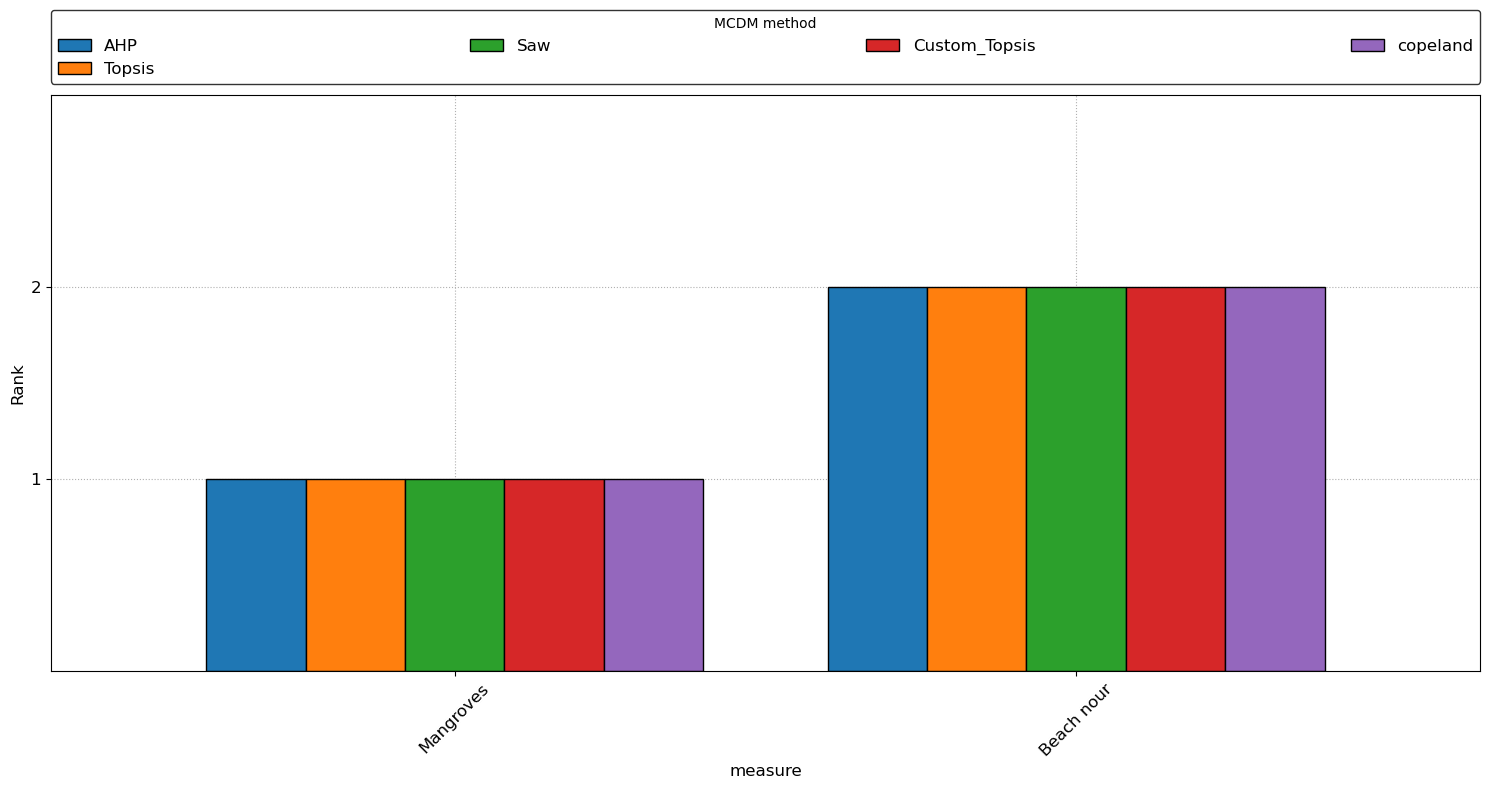

In [7]:
# Define the MCDM ranking methods
from pyrepo_mcda.mcda_methods import AHP, TOPSIS, SAW, VIKOR #  SPOTIS, ARAS, COCOSO, CODAS, COPRAS, CRADIS, EDAS, MABAC, MARCOS, MULTIMOORA, MULTIMOORA_RS, PROMETHEE_II, PROSA_C,, VMCM, WASPAS, VIKOR_SMAA
from pyrepo_mcda.compromise_rankings import copeland, dominance_directed_graph, rank_position_method
from pyrepo_mcda import distance_metrics as dists
from pyrepo_mcda import normalizations as norms


# *************** User-modifiable parameters ***************

# Define the MCDM ranking methods
mcdm_methods = {'AHP': AHP(), # Analytic Hierarchy Process default parameters
          'Topsis': TOPSIS(), # Technique for Order Preference by Similarity to Ideal Solution default parameters
          'Saw': SAW(), # Simple Additive Weighting default parameters
          'Custom_Topsis': TOPSIS(normalization_method = norms.minmax_normalization, distance_metric = dists.euclidean) # Custom method with customized normalization and distance methdods
    }

# Define the compromised ranking function of the rank matrices
comp_ranks = {'copeland': copeland,
      }

# Dictionary of derived columns and their functions
derived_columns = {'bcr': lambda df: df['ben_aai_Assets']/df['cost_Assets']}

# Apply a constraint to the decision matrix
constraints = {'ben_aai_Assets': {'greater': 0},
                 # 'cost_Assets': {'less': 5000000},
                  'bcr': {'greater': 1} # Benefit-cost ratio greater than 1 (Given the derived column above, this is equivalent to the benefit being greater than the cost)
                  }

# *************** End of user-modifiable parameters ***************


# Calculate the rankings
ranks_output = dm.calc_rankings( mcdm_methods, comp_ranks, constraints=constraints, derived_columns=derived_columns)
clear_output()


# Check if ranks_output has an attribute alt_exc_const_df
if hasattr(ranks_output, 'alt_exc_const_df'):
    # Print the alternatives that do not satisfy the constraints
    print("Table below shows the excluded alternatives, i.e., not satifying constraints,\nwhere True if particular constraint is satisfied and False if not.", 2*"\n.")
    print(tabulate(ranks_output.alt_exc_const_df, headers='keys', tablefmt='psql'))

# Plot the rankings
ranks_output.plot_ranks(disp_rnk_cols=[], rank_type='MCDM', sort_by_col='copeland', transpose=False, alt_name_col='measure')


## Part 3 – Weight sensitivities and preferences 

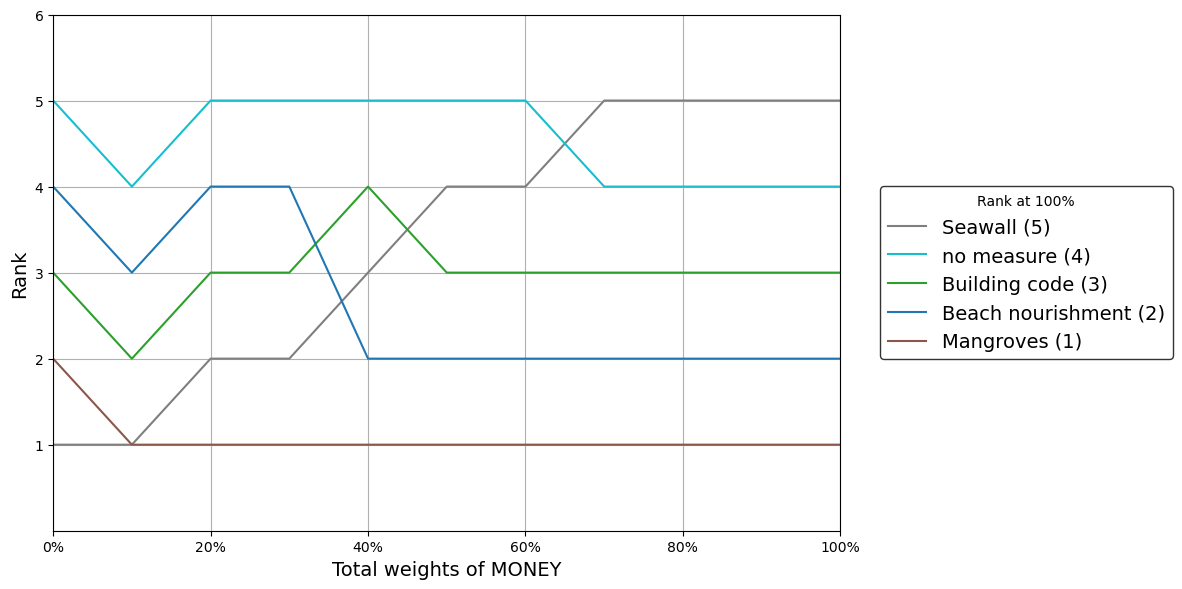

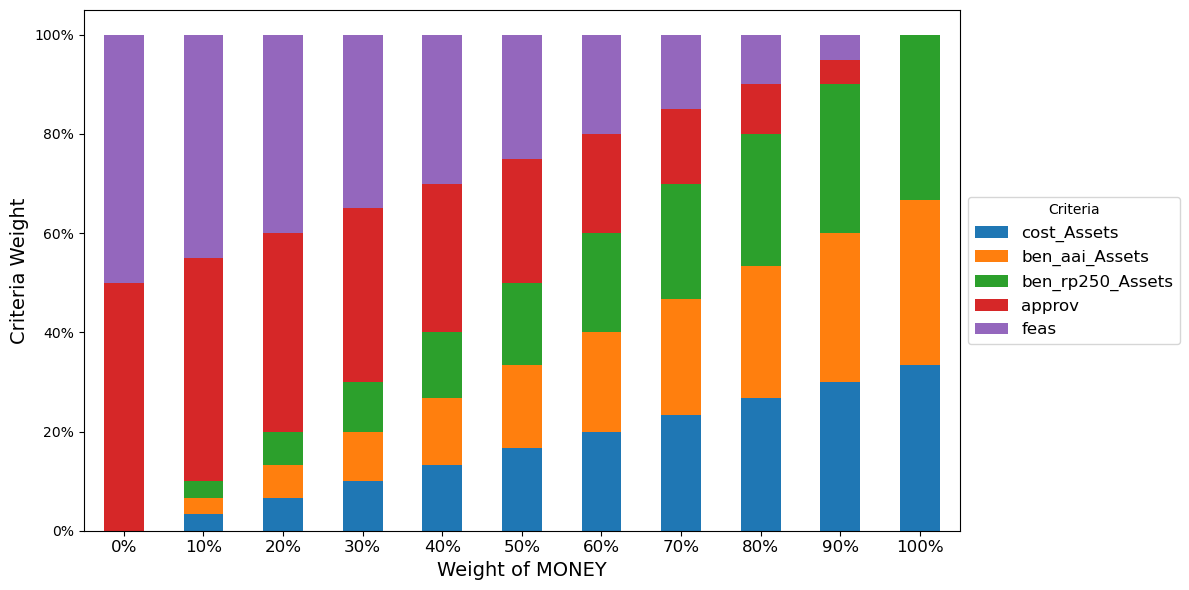

In [8]:
# If you want to check the rankings of the alternatives given the new criteria

# *************** User-modifiable parameters ***************

# Calculate the sensitivity of the rankings to the weights of the criteria
crit_cols_dict = {'MONEY': ['cost_Assets','ben_aai_Assets', 'ben_rp250_Assets']} # Dictionary of criteria categories and their criteria columns

# *************** End of user-modifiable parameters ***************

# Calculate the sensitivity of the rankings to the weights of the criteria
sensitivity_df = dm.calc_imprt_sensitivity(crit_cols_dict=crit_cols_dict, mcdm_methods=mcdm_methods, comp_ranks=comp_ranks, alt_tag='measure')

**Criteria categories**

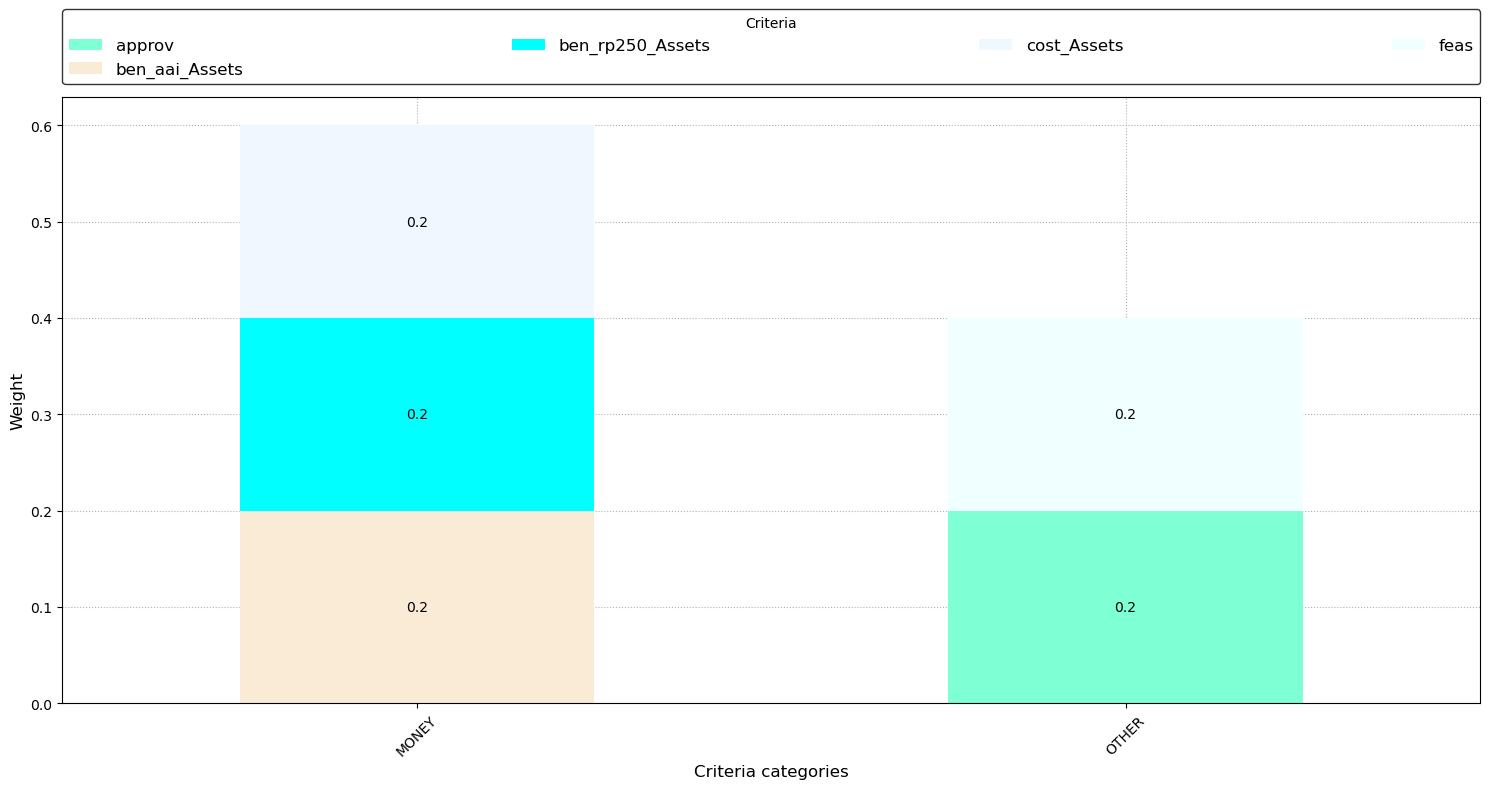

In [9]:
# Initialize the decision matrix object and include more criteria

# categorize the criteria assets and people
crit_cats = {'MONEY': ['ben_aai_Assets',  'ben_rp250_Assets', 'cost_Assets'],
             'PEOPLE': ['ben_aai_People', 'ben_rp250_People'],
             'OTHER': ['approv', 'feas']}


# Initialize the decision matrix object
dm = DecisionMatrix(metrics_df=metrics_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols, crit_cats=crit_cats)

# Plot the criteria weights
dm.plot_criteria(group_by_category=True)

## Part 3 - Incorporating uncertainties

**Define the uncertainty variables**

In [18]:
# Uncertainty variables
import scipy as sp

# *************** User-modifiable parameters ***************

# Uncertainty variable distributions
unc_var_dist_dict = {"x_ent": sp.stats.uniform(0.7, 1),
                     "m_fut_cost": sp.stats.norm(1, 0.1),
                     "x_haz_today": sp.stats.uniform(1, 3),
                     "x_haz_fut": sp.stats.uniform(1, 3)}

# Base functions
# Entity today has an uncertainty in the total asset value
def ent_today_func(x_ent, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    entity = copy.deepcopy(ent_today_base)
    entity.exposures.ref_year = CURRENT_YEAR
    entity.exposures.gdf.value *= x_ent
    return entity

# Entity in the future has a +- 10% uncertainty in the cost of all the adapatation measures
def ent_fut_func(m_fut_cost, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    entity = copy.deepcopy(ent_today_base)
    entity.exposures.ref_year = FUTURE_YEAR
    for meas in entity.measures.get_measure(haz_today_base.haz_type):
        meas.cost *= m_fut_cost
    return entity

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_today_func(x_haz_today, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    haz = copy.deepcopy(haz_today_base)
    haz.intensity = haz.intensity.multiply(x_haz_today)
    return haz

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_fut_func(x_haz_fut, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    haz = copy.deepcopy(haz_fut_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz

# *************** End of user-modifiable parameters ***************


**Genereate the metrics data frame**

In [11]:
from MCDM.utils import generate_unc_func_dist_dict

# Creaate the uncertainty functions dictionary input variable
unc_func_dist_dict = generate_unc_func_dist_dict(func_dict= {'ent_today': ent_today_func, 'ent_fut': ent_fut_func, 'haz_today': haz_today_func, 'haz_fut': haz_fut_func}, unc_var_dist_dict= unc_var_dist_dict)

# Check if the file exists
try:
    # Load previous metrics dataframe
    metrics_unc_df = pd.read_csv('Data/Metrics/{}.csv'.format(file_str + '_unc'))
except:
    #%% Generate metrics dataframe
    if file_str == 'CLIMADA_DEMO':
        n_samples = 100
    else:
        n_samples = 1 # You can increase the number of samples but very slow for the CanTho_PLFL case

    # Generate the metrics dataframe
    metrics_unc_df = generate_metrics(haz_dict, ent_dict, unc_func_dist_dict = unc_func_dist_dict, risk_fncs_dict = RISK_FNCS_DICT, n_samples= n_samples, future_year=FUTURE_YEAR, current_year=CURRENT_YEAR, file_output = file_str + '_unc')


# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
clear_output()

# Print the first few rows of the dataframe
print("\n.", "Table below shows the first few rows of the dataframe with the uncertainty samples.", 2*"\n.")
print(tabulate(metrics_unc_df.head(), headers='keys', tablefmt='psql'))


. Table below shows the first few rows of the dataframe with the uncertainty samples. 
.
.
+----+-------------------+----------+------------+----------+--------------+---------------+-------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+---------------+----------+----------+
|    | measure           | hazard   | haz_type   |    x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   ben_aai_Assets |   bcr_aai_Assets |   npv_aai_Assets |   ben_rp250_Assets |   bcr_rp250_Assets |   npv_rp250_Assets |   cost_Assets |   approv |     feas |
|----+-------------------+----------+------------+----------+--------------+---------------+-------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+---------------+----------+----------|
|  0 | Beach nourishment | TCs      | TC         | 0.703906 |     0.997062 |       1.92578 |     1.73828 |      7

**Calculate and display the ranks**

In [12]:
# *************** User-modifiable parameters ***************

# Define the uncertainty variables
unc_cols = [key for key in unc_var_dist_dict] # Columns in metrics_df that contains the uncertainty variables

# *************** End of user-modifiable parameters ***************


# Initialize the decision matrix object
dm_unc = DecisionMatrix(metrics_df=metrics_unc_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols, unc_cols=unc_cols)

# Rank the alternatives
ranks_output_unc = dm_unc.calc_rankings()
clear_output()

# Print the sample dataframe
print("\n.", "Table below shows the dataframe with the unique uncertainty samples.", 2*"\n.")
print("_"*100)
print(tabulate(dm_unc.unc_smpls_df, headers='keys', tablefmt='psql'))





. Table below shows the dataframe with the unique uncertainty samples. 
.
.
____________________________________________________________________________________________________
+-----+-------------+----------+--------------+---------------+-------------+
|     | Sample ID   |    x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |
|-----+-------------+----------+--------------+---------------+-------------|
|   0 | S1          | 0.703906 |     0.997062 |       1.92578 |     1.73828 |
|   1 | S2          | 0.703906 |     1.01276  |       2.72266 |     1.92578 |
|   2 | S3          | 0.703906 |     1.01276  |       3.98828 |     1.38672 |
|   3 | S4          | 0.703906 |     1.01276  |       3.98828 |     1.92578 |
|   4 | S5          | 0.703906 |     1.03497  |       3.98828 |     1.92578 |
|   5 | S6          | 0.703906 |     1.09316  |       2.53516 |     3.44922 |
|   6 | S7          | 0.711719 |     0.870498 |       1.99609 |     3.35547 |
|   7 | S8          | 0.711719 |     0.991

**Display the results**

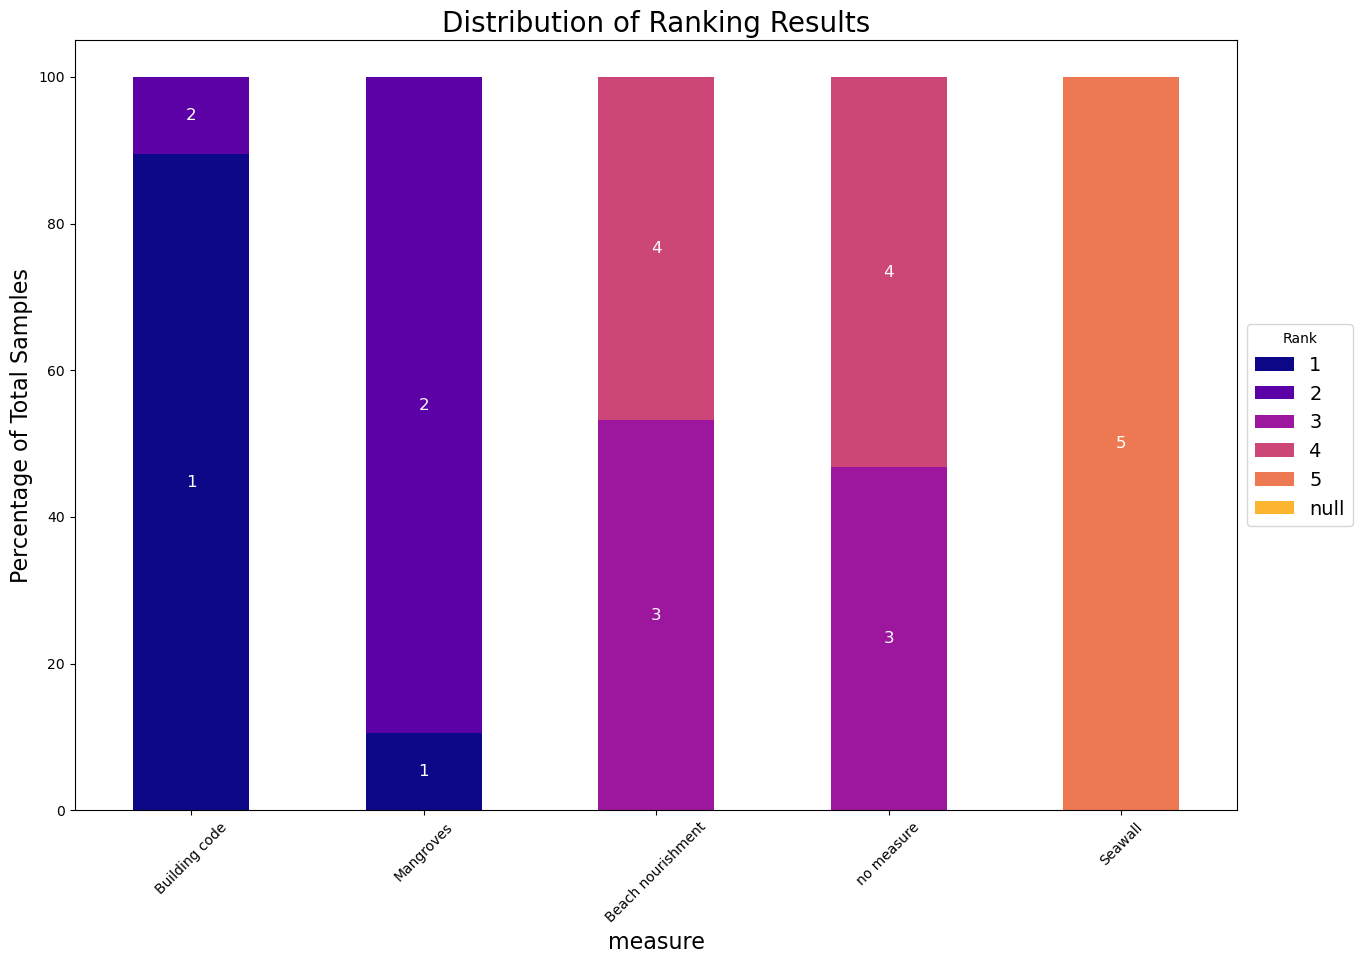

In [13]:
# Plot the rankings
ranks_output_unc.plot_rank_distribution(disp_rnk_col='copeland', alt_name_col='measure')

**Look at samples where each measure performs well and poor**

*Note: This analysis can be enhanced by integrating with the 'unsequa' module to explore how ranking sensitivities and different "scenarios" — sets of uncertainty variables — affect the performance of each alternative, both positively and negatively.e*    

In [14]:
# Print the top and bottom 5 alternatives for each measure
for measure in ranks_output_unc.ranks_MCDM_df['measure'].unique():
    # Filter the dataframe for the current measure
    measure_df = ranks_output_unc.ranks_MCDM_df[ranks_output_unc.ranks_MCDM_df['measure'] == measure]
    # Drop the Group ID column
    measure_df.drop(columns='Group ID', inplace=True)

    # Sort the filtered dataframe on the 'copeland' column
    measure_df.sort_values(by='copeland', ascending=True, inplace=True)

    # Print the top 5 alternatives
    print(f"The top 5 alternatives for the measure {measure} are:")
    print(tabulate(measure_df.head(5), headers='keys', tablefmt='psql'))

    # Print the bottom 5 alternatives
    print(f"The bottom 5 alternatives for the measure {measure} are:")
    print(tabulate(measure_df.tail(5), headers='keys', tablefmt='psql'))

    print('---------------------------')
    print("\n.")


The top 5 alternatives for the measure Beach nourishment are:
+------+------------------+-------------------+-------------+----------+--------------+---------------+-------------+-------+----------+-------+------------+
|      | Alternative ID   | measure           | Sample ID   |    x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   AHP |   Topsis |   Saw |   copeland |
|------+------------------+-------------------+-------------+----------+--------------+---------------+-------------+-------+----------+-------+------------|
|    0 | A1               | Beach nourishment | S1          | 0.703906 |     0.997062 |       1.92578 |     1.73828 |     3 |        3 |     4 |          3 |
| 1780 | A1               | Beach nourishment | S357        | 1.29766  |     0.938577 |       1.08203 |     1.26953 |     3 |        3 |     4 |          3 |
| 1775 | A1               | Beach nourishment | S356        | 1.29766  |     0.874901 |       1.08203 |     1.26953 |     3 |        3 |     4 |    

**Filter specific samples to rank**

In [15]:
# *************** User-modifiable parameters ***************

# Define the condition
rank_filt = {'m_fut_cost': {'range': (1.1, 1.2)},
               'x_haz_today': {'greater': 1.5}
               }

# *************** End of user-modifiable parameters ***************

# Rank the alternatives
filt_ranks_output_unc = dm_unc.calc_rankings(rank_filt=rank_filt)

# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
clear_output()

# Print the rankings
filt_ranks_output_unc.print_rankings()



State: S16
-----------------------------------
+------------------+-------------------+----------+--------------+---------------+-------------+-------+----------+-------+------------+
| Alternative ID   | measure           |    x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   AHP |   Topsis |   Saw |   copeland |
|------------------+-------------------+----------+--------------+---------------+-------------+-------+----------+-------+------------|
| A1               | Beach nourishment | 0.719531 |      1.13417 |       1.50391 |     3.28516 |     3 |        3 |     4 |          3 |
| A2               | Building code     | 0.719531 |      1.13417 |       1.50391 |     3.28516 |     1 |        1 |     1 |          1 |
| A3               | Mangroves         | 0.719531 |      1.13417 |       1.50391 |     3.28516 |     2 |        2 |     2 |          2 |
| A4               | Seawall           | 0.719531 |      1.13417 |       1.50391 |     3.28516 |     5 |        5 |     5 |        

**Derive criteria as the conditional mean**  

*This approach is useful for analyzing specific scenarios, i.e., sets of uncertainty variables.*

The plot below shows the rankings of the alternatives based on the conditional mean of the criteria. 
.
.
+------------------+-------------------+-------+----------+-------+-----------------+------------+
| Alternative ID   | measure           |   AHP |   Topsis |   Saw |   Custom_Topsis |   copeland |
|------------------+-------------------+-------+----------+-------+-----------------+------------|
| A2               | Building code     |     1 |        1 |     1 |               1 |          1 |
| A3               | Mangroves         |     2 |        2 |     2 |               2 |          2 |
| A1               | Beach nourishment |     3 |        3 |     4 |               3 |          3 |
| A5               | no measure        |     4 |        4 |     3 |               4 |          4 |
| A4               | Seawall           |     5 |        5 |     5 |               5 |          5 |
+------------------+-------------------+-------+----------+-------+-----------------+------------+




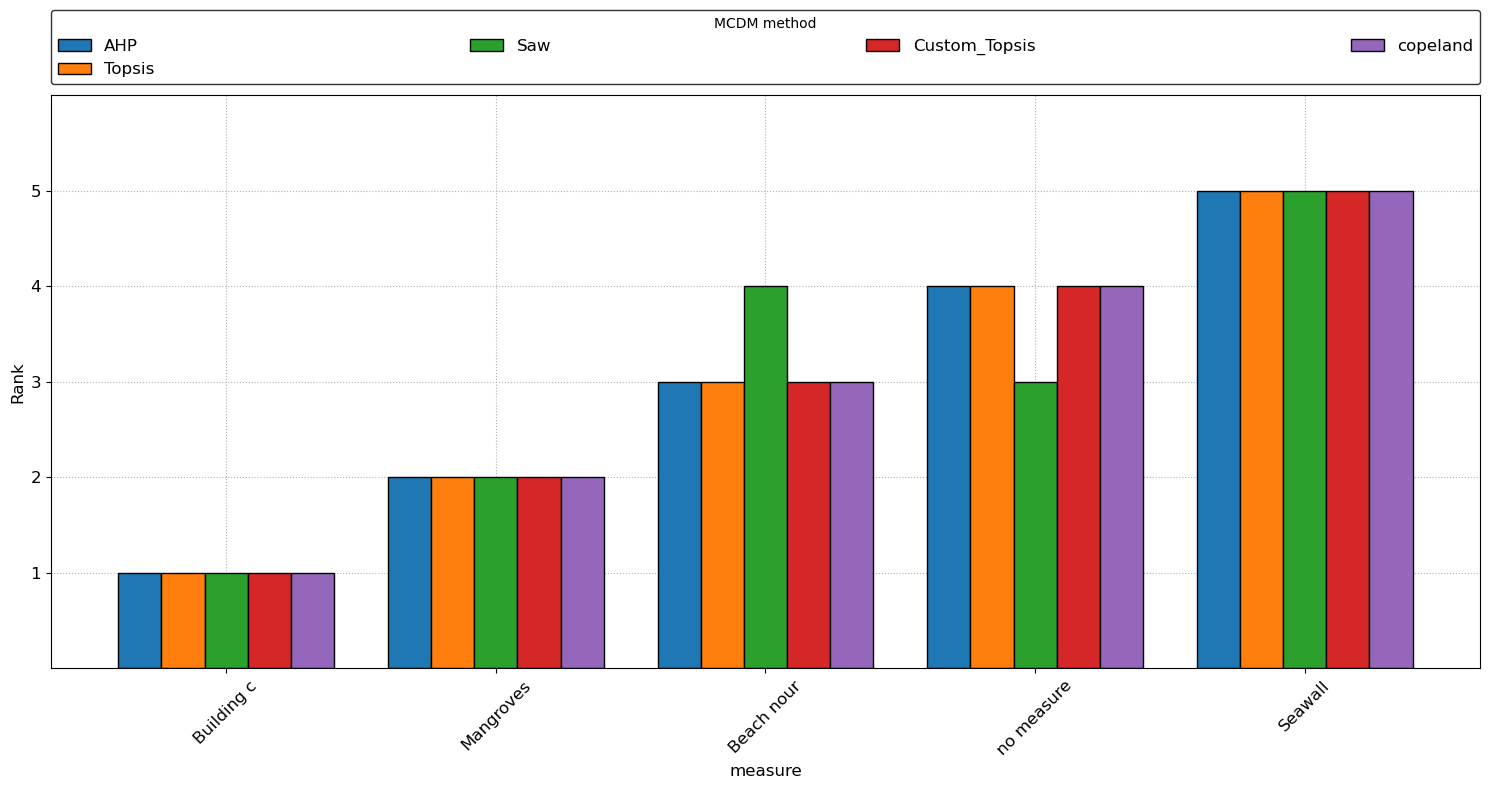

In [16]:
# *************** User-modifiable parameters ***************

# Define the condition
condition = {'m_fut_cost': {'greater': 1} # The future cost of the adaptation measures is greater than 1
                  }

# *************** End of user-modifiable parameters ***************

# Calculate the conditional mean based criteria
dm_cond_unc_mean = dm_unc.mean_based_criteria(condition=condition)

# Calculate the rankings
rnks_cond_unc_mean = dm_cond_unc_mean.calc_rankings( mcdm_methods, comp_ranks)

# Plot the rankings
print("The plot below shows the rankings of the alternatives based on the conditional mean of the criteria.", 2*"\n.")
rnks_cond_unc_mean.print_rankings(sort_by_col='copeland')
rnks_cond_unc_mean.plot_ranks(sort_by_col='copeland', alt_name_col='measure')

## Part 4 - Considering Groups (Only works for file_str = 'CanTho_PLFL': Go back to Part 1)

In [17]:
# If you look at the entities exposure object, you will see that the exposure geodataframe has a description column "admin1_info"

# Print the first few rows of the exposure geodataframe
print(tabulate(ent_dict['Assets']['today'].exposures.gdf.head(), headers='keys', tablefmt='psql'))

# Print the unique set of groups in admin1_info
print("The unique set of groups in the admin1_info column is:")
print(ent_dict['Assets']['today'].exposures.gdf.admin1_info.unique())


+----+------------+-------------+-------------+--------------+-------------+-----------+--------------+
|    |   latitude |   longitude |       value |   deductible |       cover |   impf_TC |   Value_2010 |
|----+------------+-------------+-------------+--------------+-------------+-----------+--------------|
|  0 |    26.9339 |    -80.1288 | 1.39275e+10 |            0 | 1.39275e+10 |         1 |  5.1393e+09  |
|  1 |    26.9572 |    -80.0983 | 1.25961e+10 |            0 | 1.25961e+10 |         1 |  4.64799e+09 |
|  2 |    26.7838 |    -80.7489 | 1.25961e+10 |            0 | 1.25961e+10 |         1 |  4.64799e+09 |
|  3 |    26.6455 |    -80.5507 | 1.25961e+10 |            0 | 1.25961e+10 |         1 |  4.64799e+09 |
|  4 |    26.8978 |    -80.5969 | 1.25961e+10 |            0 | 1.25961e+10 |         1 |  4.64799e+09 |
+----+------------+-------------+-------------+--------------+-------------+-----------+--------------+
The unique set of groups in the admin1_info column is:


AttributeError: 'GeoDataFrame' object has no attribute 'admin1_info'

**Calc the metrics for each group**

In [ ]:
# Generate the metrics dataframe but with the admin1_info column as a group column

# Check if the file exists
try:
    # Load previous metrics dataframe
    metrics_group_df = pd.read_csv('Data/Metrics/{}.csv'.format(file_str + '_group'))
except:
    #%% Generate metrics dataframe
    metrics_group_df = generate_metrics(haz_dict, ent_dict, groups = ['admin1_info'], risk_fncs_dict = RISK_FNCS_DICT, future_year=FUTURE_YEAR, current_year=CURRENT_YEAR, file_output = file_str + '_group')

# Filter out the 'ALL' group which is simply the the exposure data for the entire region
metrics_group_df = metrics_group_df[metrics_group_df['admin1_info'] != 'ALL']
# ALso filter out the 'unknown' group to make the graph more readable
metrics_group_df = metrics_group_df[metrics_group_df['admin1_info'] != 'unknown']


**Initialize the dm object**

In [ ]:
# *************** User-modifiable parameters ***************

# Define the internal group weights (default is equal if none is defined) which should sum to 1
group_weights = {'admin1_info': {'Vĩnh Long': 0.7, 'Hau Giang': 0.3}}

# *************** End of user-modifiable parameters ***************


# Initialize the decision matrix object
dm_groups = DecisionMatrix(metrics_df=metrics_group_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols,
                           group_cols=['admin1_info'], group_weights= group_weights )

# Print the groups
print(2*'.\n')
print('The available groups and the internal group weights for the specific group are:')
print('---------------------------')
print(tabulate(dm_groups.group_weights['admin1_info'], headers='keys', tablefmt='psql'))

**Calc ranks for each group**

In [ ]:
# You can either look at the rankings of the alternatives for each group or the rankings of the groups themselves
# Rank the alternatives
ranks_output = dm_groups.calc_rankings()

# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
# However, if intrested in the output, comment the following line
clear_output()

# Print the rankings
print('The performance of the alternatives for each group based on the criteria is:')
ranks_output.print_rankings()



**Pivot the groups to create new criteria**

In [ ]:
# *************** User-modifiable parameters ***************

group_by_category = True # Select True if the criteria should be grouped by category

# *************** End of user-modifiable parameters ***************


# Or you can create a new decision matrix object with the groups as alternatives and the criteria as the alternatives
dm_piv = dm_groups.pivot_and_reweight_criteria(piv_col='admin1_info')

# Plot the criteria weights
dm_piv.plot_criteria(group_by_category=group_by_category)

# Rank the groups
ranks_output = dm_piv.calc_rankings()

# Print the rankings
ranks_output.plot_ranks(sort_by_col='copeland', alt_name_col='measure')
